## Neural Network
In this exercise, we will use Neural Networks to perform Linear Regression.

The objective is to build a 2-hidden layers fully connected neural network (a.k.a multilayer perceptron) with TensorFlow using some of the higher-level wrappers (tf.estimators, tf.layers, tf.metrics, ...), you can check 'neural_network_raw' example for a raw, and more detailed TensorFlow implementation.

Further, we will use the MNIST Dataset used in the last exercise.

In [1]:
from __future__ import print_function

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Set the parameters.

In [2]:
learning_rate = 0.1
num_steps = 300
batch_size = 128

# Network Parameters
n_hidden_1 = 128 # 1st layer number of neurons
n_hidden_2 = 128 # 2nd layer number of neurons
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)

Define the input function for training. **mnist.train.images**

In [3]:
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.train.images}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)

Define the neural network.

In [4]:
def neural_net(x_dict):
    # TF Estimator input is a dict, in case of multiple inputs
    x = x_dict['images']
    # Hidden fully connected layer with 128 neurons
    layer_1 = tf.layers.dense(x, n_hidden_1)
    # Hidden fully connected layer with 128 neurons
    layer_2 = tf.layers.dense(layer_1, num_classes)
    # Output fully connected layer with a neuron for each class
    out_layer = tf.layers.dense(layer_2, n_hidden_2)
    return out_layer

Define the model function (following __[TF Estimator Template](https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator)__).

In [5]:
def model_fn(features, labels, mode):
    
    # Build the neural network
    logits = neural_net(features)
    
    # Predictions
    pred_classes = tf.argmax(logits, axis=1)
    pred_probas = tf.nn.softmax(logits)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

Build the Estimator.

In [6]:
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}


Train the Model.

In [7]:
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpk15o_305/model.ckpt.
INFO:tensorflow:loss = 4.96094, step = 1
INFO:tensorflow:global_step/sec: 216.275
INFO:tensorflow:loss = 0.687012, step = 101 (0.464 sec)
INFO:tensorflow:global_step/sec: 184.206
INFO:tensorflow:loss = 0.336877, step = 201 (0.543 sec)
INFO:tensorflow:Saving checkpoints for 300 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpk15o_305/model.ckpt.
INFO:tensorflow:Loss for final step: 0.432115.


Evaluate the Model (**mnist.test.images**). Define the input function for evaluating.

In [8]:
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Starting evaluation at 2017-10-28-23:23:13
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpk15o_305/model.ckpt-300
INFO:tensorflow:Finished evaluation at 2017-10-28-23:23:13
INFO:tensorflow:Saving dict for global step 300: accuracy = 0.8871, global_step = 300, loss = 0.376966


{'accuracy': 0.88709998, 'global_step': 300, 'loss': 0.37696627}

We now test the prediction for 10000 images.

In [9]:
# Predict single images
n_images = 10000
# Get images from test set
test_images = mnist.test.images[:n_images]
test_labels = mnist.test.labels[:n_images]
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))
y_list = list(test_labels)

# Display
correct_count = 0
for i in range(n_images):
#     plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
#     plt.show()
#     print("Model prediction:", preds[i])
#     print("true value:",y_list[i])
    if preds[i] == y_list[i]:
        correct_count += 1
        
print("Testing accuracy:", float(correct_count)/float(n_images))
        

INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpk15o_305/model.ckpt-300
Testing accuracy: 0.8871


## Q1. Plot training error and testing error vs steps 

For the same input settings, train and evaluate the model without regularization or dropout. Plot a graph with y axis being the training accuracy and test accuracy, and x-axis being the number of steps.

In [6]:
# Training data
input_fn_train = tf.estimator.inputs.numpy_input_fn(
    x = {'images': mnist.train.images}, y = mnist.train.labels,
    batch_size = batch_size, num_epochs = None, shuffle = True)

# Initialize lists
acc_train = []

for step in list(range(10, num_steps + 1, 10)):
    # Build the estimator
    model = tf.estimator.Estimator(model_fn)
    
    # Train the model
    model.train(input_fn_train, steps = step)
    
    # training accuracy
    temp_train = tf.estimator.inputs.numpy_input_fn(
        x = {'images': mnist.train.images}, y = mnist.train.labels,
        batch_size = batch_size, shuffle = False)
    # Use the Estimator 'evaluate' method
    acc_train.append(model.evaluate(temp_train)["accuracy"])

# test accuracy
temp_test = tf.estimator.inputs.numpy_input_fn(
    x = {'images': mnist.test.images}, y = mnist.test.labels,
    batch_size = batch_size, shuffle = False)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmp1xgta77o/model.ckpt.
INFO:tensorflow:loss = 4.93175, step = 1
INFO:tensorflow:Saving checkpoints for 10 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmp1xgta77o/model.ckpt.
INFO:tensorflow:Loss for final step: 2.73969.
INFO:tensorflow:Starting evaluation at 2017-10-29-00:00:54
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmp1xgta77o/model.ckpt-10
INFO:tensorflow:Finished evaluation at 2017-10-29-00:00:55
INFO:tensorflow:Saving dict for global step 10: accuracy = 0.246055, global_step = 10, loss = 2.49571
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpmv_m2qzo/

INFO:tensorflow:loss = 4.88992, step = 1
INFO:tensorflow:Saving checkpoints for 90 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpk3pyp1kw/model.ckpt.
INFO:tensorflow:Loss for final step: 0.497467.
INFO:tensorflow:Starting evaluation at 2017-10-29-00:01:33
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpk3pyp1kw/model.ckpt-90
INFO:tensorflow:Finished evaluation at 2017-10-29-00:01:35
INFO:tensorflow:Saving dict for global step 90: accuracy = 0.831909, global_step = 90, loss = 0.582014
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmppbsc9mpc/model.ckpt.
INFO:tensorflow:loss = 4.82875, step = 1
INFO:tensorflow:Saving checkpoints for 100 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmppbsc9mpc/model.ckpt.
INFO:tensorflow:Loss for final step: 0.633236.
INFO:tensor

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpgh7f_zxs/model.ckpt.
INFO:tensorflow:loss = 4.84494, step = 1
INFO:tensorflow:global_step/sec: 138.312
INFO:tensorflow:loss = 0.483019, step = 101 (0.724 sec)
INFO:tensorflow:Saving checkpoints for 170 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpgh7f_zxs/model.ckpt.
INFO:tensorflow:Loss for final step: 0.588854.
INFO:tensorflow:Starting evaluation at 2017-10-29-00:02:16
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpgh7f_zxs/model.ckpt-170
INFO:tensorflow:Finished evaluation at 2017-10-29-00:02:18
INFO:tensorflow:Saving dict for global step 170: accuracy = 0.872, global_step = 170, loss = 0.436016
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:te

INFO:tensorflow:loss = 0.397867, step = 101 (0.706 sec)
INFO:tensorflow:global_step/sec: 143.626
INFO:tensorflow:loss = 0.556092, step = 201 (0.696 sec)
INFO:tensorflow:Saving checkpoints for 240 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpf7zu_7z5/model.ckpt.
INFO:tensorflow:Loss for final step: 0.509964.
INFO:tensorflow:Starting evaluation at 2017-10-29-00:02:58
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpf7zu_7z5/model.ckpt-240
INFO:tensorflow:Finished evaluation at 2017-10-29-00:03:00
INFO:tensorflow:Saving dict for global step 240: accuracy = 0.887255, global_step = 240, loss = 0.394669
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpm7n48tfw/model.ckpt.
INFO:tensorflow:loss = 4.89894, step = 1
INFO:tensorflow:global_step/sec: 137.953
INFO:tensorflow:loss =

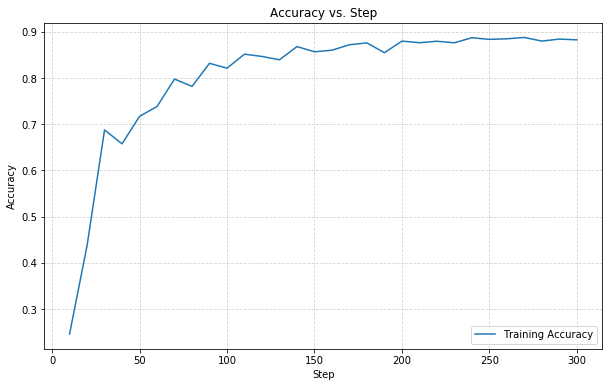

In [7]:
# Display the graph
fig, ax = plt.subplots(figsize = (10, 6))
X = list(range(10, num_steps + 1, 10))
plt.plot(X, acc_train, label = "Training Accuracy")

plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Step')
plt.legend(loc = "lower right")
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

In [19]:
# Build the estimator
model = tf.estimator.Estimator(model_fn)
    
# Train the model
model.train(input_fn_train, steps = num_steps)

# Use the Estimator 'evaluate' method
model.evaluate(temp_test)["accuracy"]

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmp6usoa8d0/model.ckpt.
INFO:tensorflow:loss = 4.95054, step = 1
INFO:tensorflow:global_step/sec: 127.404
INFO:tensorflow:loss = 0.587231, step = 101 (0.788 sec)
INFO:tensorflow:global_step/sec: 99.8969
INFO:tensorflow:loss = 0.257809, step = 201 (0.999 sec)
INFO:tensorflow:Saving checkpoints for 300 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmp6usoa8d0/model.ckpt.
INFO:tensorflow:Loss for final step: 0.442798.
INFO:tensorflow:Starting evaluation at 2017-10-29-00:06:03
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmp6usoa8d0/model.ckpt-300
INFO:tensorflow:Finished evaluation at 2017-10-29-00:06:03
INFO:tensorflow:Saving dict for global step 300: accuracy = 0.8827, global_step = 300, loss = 0.387357


0.88270003

The test accuracy is **0.8827** without regularization or dropouts.

## Q2. Plot training error and testing error vs steps WITH regularization


For the same input settings, train and evaluate the model with regularization. 
By trial and error, choose a regularization parameter that improves the teset accuracy (change the architecture such as the number of layers and/or the number of nodes in th elayer, batch size, etc if you need to).
Plot a graph with y axis being the training accuracy and test accuracy, and x-axis being the number of steps.


Here we add L2 norms with regularization constant 0.1 for regularization.

Reference: https://www.tensorflow.org/api_docs/python/tf/layers/dense

In [58]:
#------------------ Your code here -------------------#
learning_rate = 0.1
num_steps = 300
batch_size = 500

# Network Parameters
n_hidden_1 = 128 # 1st layer number of neurons
n_hidden_2 = 128 # 2nd layer number of neurons
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)


def neural_net(x_dict):
    # TF Estimator input is a dict, in case of multiple inputs
    x = x_dict['images']
    l2_regularizer = tf.contrib.layers.l2_regularizer(scale = 0.1)
    # Hidden fully connected layer with 128 neurons
    layer_1 = tf.layers.dense(x, n_hidden_1, kernel_regularizer = l2_regularizer)
    # Hidden fully connected layer with 128 neurons
    layer_2 = tf.layers.dense(layer_1, num_classes, kernel_regularizer = l2_regularizer)
    # Output fully connected layer with a neuron for each class
    out_layer = tf.layers.dense(layer_2, n_hidden_2, kernel_regularizer = l2_regularizer)
    return out_layer
# -----------------------------------------------------#

In [7]:
# Training data
input_fn_train = tf.estimator.inputs.numpy_input_fn(
    x = {'images': mnist.train.images}, y = mnist.train.labels,
    batch_size = batch_size, num_epochs = None, shuffle = True)

# Initialize lists
acc_train = []

for step in list(range(10, num_steps + 1, 10)):
    # Build the estimator
    model = tf.estimator.Estimator(model_fn)
    
    # Train the model
    model.train(input_fn_train, steps = step)
    
    # training accuracy
    temp_train = tf.estimator.inputs.numpy_input_fn(
        x = {'images': mnist.train.images}, y = mnist.train.labels,
        batch_size = batch_size, shuffle = False)
    # Use the Estimator 'evaluate' method
    acc_train.append(model.evaluate(temp_train)["accuracy"])


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmp0270e30b/model.ckpt.
INFO:tensorflow:loss = 4.81978, step = 1
INFO:tensorflow:Saving checkpoints for 10 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmp0270e30b/model.ckpt.
INFO:tensorflow:Loss for final step: 2.54461.
INFO:tensorflow:Starting evaluation at 2017-10-28-23:50:02
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmp0270e30b/model.ckpt-10
INFO:tensorflow:Finished evaluation at 2017-10-28-23:50:04
INFO:tensorflow:Saving dict for global step 10: accuracy = 0.349727, global_step = 10, loss = 2.26965
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmptgccocfx/

INFO:tensorflow:loss = 4.88824, step = 1
INFO:tensorflow:Saving checkpoints for 90 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmp90lzbxaq/model.ckpt.
INFO:tensorflow:Loss for final step: 0.468879.
INFO:tensorflow:Starting evaluation at 2017-10-28-23:50:37
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmp90lzbxaq/model.ckpt-90
INFO:tensorflow:Finished evaluation at 2017-10-28-23:50:39
INFO:tensorflow:Saving dict for global step 90: accuracy = 0.820145, global_step = 90, loss = 0.600319
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpuomtcn2t/model.ckpt.
INFO:tensorflow:loss = 4.82119, step = 1
INFO:tensorflow:Saving checkpoints for 100 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpuomtcn2t/model.ckpt.
INFO:tensorflow:Loss for final step: 0.591179.
INFO:tensor

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpl46jcv4_/model.ckpt.
INFO:tensorflow:loss = 4.92017, step = 1
INFO:tensorflow:global_step/sec: 163.437
INFO:tensorflow:loss = 0.531459, step = 101 (0.613 sec)
INFO:tensorflow:Saving checkpoints for 170 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpl46jcv4_/model.ckpt.
INFO:tensorflow:Loss for final step: 0.404449.
INFO:tensorflow:Starting evaluation at 2017-10-28-23:51:14
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpl46jcv4_/model.ckpt-170
INFO:tensorflow:Finished evaluation at 2017-10-28-23:51:15
INFO:tensorflow:Saving dict for global step 170: accuracy = 0.872091, global_step = 170, loss = 0.439429
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO

INFO:tensorflow:loss = 0.380289, step = 101 (0.693 sec)
INFO:tensorflow:global_step/sec: 143.766
INFO:tensorflow:loss = 0.394311, step = 201 (0.696 sec)
INFO:tensorflow:Saving checkpoints for 240 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmp8f823vdc/model.ckpt.
INFO:tensorflow:Loss for final step: 0.366037.
INFO:tensorflow:Starting evaluation at 2017-10-28-23:51:50
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmp8f823vdc/model.ckpt-240
INFO:tensorflow:Finished evaluation at 2017-10-28-23:51:51
INFO:tensorflow:Saving dict for global step 240: accuracy = 0.873964, global_step = 240, loss = 0.425279
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpb1i_mnbr/model.ckpt.
INFO:tensorflow:loss = 4.90867, step = 1
INFO:tensorflow:global_step/sec: 142.216
INFO:tensorflow:loss =

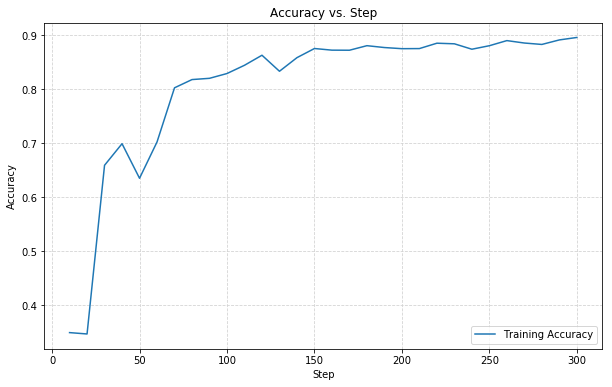

In [23]:
# Display the graph
fig, ax = plt.subplots(figsize = (10, 6))
X = list(range(10, num_steps + 1, 10))
plt.plot(X, acc_train, label = "Training Accuracy")

plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Step')
plt.legend(loc = "lower right")
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

In [60]:
# Build the estimator
model = tf.estimator.Estimator(model_fn)
    
# Train the model
model.train(input_fn_train, steps = num_steps)

# Test data
temp_test = tf.estimator.inputs.numpy_input_fn(
    x = {'images': mnist.test.images}, y = mnist.test.labels,
    batch_size = batch_size, shuffle = False)

# Use the Estimator 'evaluate' method
model.evaluate(temp_test)["accuracy"]

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpa1onon8i/model.ckpt.
INFO:tensorflow:loss = 4.91557, step = 1
INFO:tensorflow:global_step/sec: 86.9325
INFO:tensorflow:loss = 0.600901, step = 101 (1.152 sec)
INFO:tensorflow:global_step/sec: 69.1346
INFO:tensorflow:loss = 0.368048, step = 201 (1.447 sec)
INFO:tensorflow:Saving checkpoints for 300 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpa1onon8i/model.ckpt.
INFO:tensorflow:Loss for final step: 0.163775.
INFO:tensorflow:Starting evaluation at 2017-10-29-00:18:15
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpa1onon8i/model.ckpt-300
INFO:tensorflow:Finished evaluation at 2017-10-29-00:18:15
INFO:tensorflow:Saving dict for global step 300: accuracy = 0.9009, global_step = 300, loss = 0.341075


0.90090001

The test accuracy is **0.9009** with l2 regularization, which has some slight improvement compared to Q1.

## Q3. Plot training error and testing error vs steps with dropout


For the same input settings, train and evaluate the model with dropout but without regularization. 
Through trial-and-error find a dropout rate that improves the test accuracy (change the architecture such as the number of layers and/or the number of nodes in th elayer, batch size, etc if you need to).
Plot a graph with y axis being the training accuracy and test accuracy, and x-axis being the number of steps.

Here we set **dropout rate = 0.4**, and see if the test accuracy could increase.

In [61]:
#------------------ Your code here -------------------#
learning_rate = 0.1
num_steps = 300
batch_size = 256

# Network Parameters
n_hidden_1 = 128 # 1st layer number of neurons
n_hidden_2 = 128 # 2nd layer number of neurons
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)


def neural_net(x_dict):
    # TF Estimator input is a dict, in case of multiple inputs
    x = x_dict['images']
    
    # Hidden fully connected layer with 128 neurons
    layer_1 = tf.layers.dense(x, n_hidden_1)
    layer_1_dropout = tf.layers.dropout(
        inputs = layer_1, rate = 0.4)
    
    # Hidden fully connected layer with 128 neurons
    layer_2 = tf.layers.dense(layer_1_dropout, num_classes)
    layer_2_dropout = tf.layers.dropout(
        inputs = layer_2, rate = 0.4)
    
    # Output fully connected layer with a neuron for each class
    out_layer = tf.layers.dense(layer_2_dropout, n_hidden_2)
    return out_layer
# -----------------------------------------------------#

In [62]:
# Training data
input_fn_train = tf.estimator.inputs.numpy_input_fn(
    x = {'images': mnist.train.images}, y = mnist.train.labels,
    batch_size = batch_size, num_epochs = None, shuffle = True)

# Initialize lists
acc_train = []

for step in list(range(10, num_steps + 1, 10)):
    # Build the estimator
    model = tf.estimator.Estimator(model_fn)
    
    # Train the model
    model.train(input_fn_train, steps = step)
    
    # training accuracy
    temp_train = tf.estimator.inputs.numpy_input_fn(
        x = {'images': mnist.train.images}, y = mnist.train.labels,
        batch_size = batch_size, shuffle = False)
    # Use the Estimator 'evaluate' method
    acc_train.append(model.evaluate(temp_train)["accuracy"])


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpjzzt6k8k/model.ckpt.
INFO:tensorflow:loss = 4.87209, step = 1
INFO:tensorflow:Saving checkpoints for 10 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpjzzt6k8k/model.ckpt.
INFO:tensorflow:Loss for final step: 3.41686.
INFO:tensorflow:Starting evaluation at 2017-10-29-00:19:07
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpjzzt6k8k/model.ckpt-10
INFO:tensorflow:Finished evaluation at 2017-10-29-00:19:08
INFO:tensorflow:Saving dict for global step 10: accuracy = 0.214309, global_step = 10, loss = 3.01983
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpqzbjglha/

INFO:tensorflow:loss = 4.86744, step = 1
INFO:tensorflow:Saving checkpoints for 90 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpt22_59il/model.ckpt.
INFO:tensorflow:Loss for final step: 0.533115.
INFO:tensorflow:Starting evaluation at 2017-10-29-00:19:45
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpt22_59il/model.ckpt-90
INFO:tensorflow:Finished evaluation at 2017-10-29-00:19:47
INFO:tensorflow:Saving dict for global step 90: accuracy = 0.838818, global_step = 90, loss = 0.581974
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpmxonr7bo/model.ckpt.
INFO:tensorflow:loss = 4.92274, step = 1
INFO:tensorflow:Saving checkpoints for 100 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpmxonr7bo/model.ckpt.
INFO:tensorflow:Loss for final step: 0.54331.
INFO:tensorf

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpr5i1lf3q/model.ckpt.
INFO:tensorflow:loss = 4.85466, step = 1
INFO:tensorflow:global_step/sec: 96.1395
INFO:tensorflow:loss = 0.418311, step = 101 (1.041 sec)
INFO:tensorflow:Saving checkpoints for 170 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpr5i1lf3q/model.ckpt.
INFO:tensorflow:Loss for final step: 0.41409.
INFO:tensorflow:Starting evaluation at 2017-10-29-00:20:25
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpr5i1lf3q/model.ckpt-170
INFO:tensorflow:Finished evaluation at 2017-10-29-00:20:26
INFO:tensorflow:Saving dict for global step 170: accuracy = 0.872436, global_step = 170, loss = 0.446584
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:

INFO:tensorflow:loss = 0.536866, step = 101 (1.194 sec)
INFO:tensorflow:global_step/sec: 84.4199
INFO:tensorflow:loss = 0.397664, step = 201 (1.185 sec)
INFO:tensorflow:Saving checkpoints for 240 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpkse4typp/model.ckpt.
INFO:tensorflow:Loss for final step: 0.472878.
INFO:tensorflow:Starting evaluation at 2017-10-29-00:21:06
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpkse4typp/model.ckpt-240
INFO:tensorflow:Finished evaluation at 2017-10-29-00:21:07
INFO:tensorflow:Saving dict for global step 240: accuracy = 0.882127, global_step = 240, loss = 0.400797
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpn2sl_zlo/model.ckpt.
INFO:tensorflow:loss = 4.81886, step = 1
INFO:tensorflow:global_step/sec: 83.8066
INFO:tensorflow:loss =

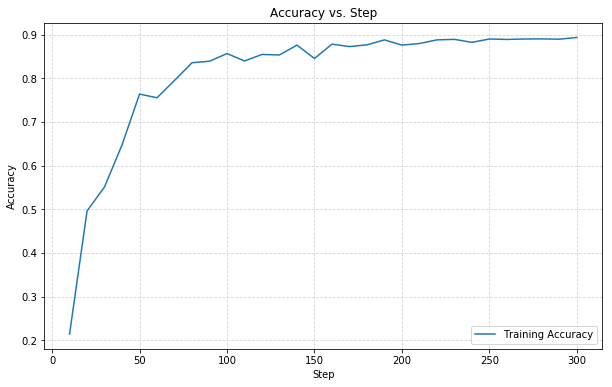

In [63]:
# Display the graph
fig, ax = plt.subplots(figsize = (10, 6))
X = list(range(10, num_steps + 1, 10))
plt.plot(X, acc_train, label = "Training Accuracy")

plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Step')
plt.legend(loc = "lower right")
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

In [64]:
# Build the estimator
model = tf.estimator.Estimator(model_fn)
    
# Train the model
model.train(input_fn_train, steps = num_steps)

# Test data
temp_test = tf.estimator.inputs.numpy_input_fn(
    x = {'images': mnist.test.images}, y = mnist.test.labels,
    batch_size = batch_size, shuffle = False)

# Use the Estimator 'evaluate' method
model.evaluate(temp_test)["accuracy"]

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpikirqvll/model.ckpt.
INFO:tensorflow:loss = 4.84758, step = 1
INFO:tensorflow:global_step/sec: 71.9504
INFO:tensorflow:loss = 0.691824, step = 101 (1.391 sec)
INFO:tensorflow:global_step/sec: 73.0531
INFO:tensorflow:loss = 0.519429, step = 201 (1.369 sec)
INFO:tensorflow:Saving checkpoints for 300 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpikirqvll/model.ckpt.
INFO:tensorflow:Loss for final step: 0.439481.
INFO:tensorflow:Starting evaluation at 2017-10-29-00:23:00
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpikirqvll/model.ckpt-300
INFO:tensorflow:Finished evaluation at 2017-10-29-00:23:01
INFO:tensorflow:Saving dict for global step 300: accuracy = 0.901, global_step = 300, loss = 0.336518


0.90100002

The test accuracy is **0.9010** with dropout rate = 0.4, which also shows improvement.

In conclusion, 

| Method           | Test Accuracy |
|:-------------:   |:-------------:|
| None             | 0.8827        | 
| L2 Regularization| 0.9009        |  
| Dropout          | 0.9010        |   